In [1]:
%cd '/scratch/sk7898/l3embedding/classifier/sonyc_ust'
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import os
import random
import csv
import json
import glob
import pandas as pd
import pickle as pk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import resampy
import tensorflow as tf
import librosa
import keras
from sklearn.preprocessing import StandardScaler
from keras.models import load_model
from matplotlib import cm
from metrics import parse_coarse_prediction, micro_averaged_auprc, macro_averaged_auprc, evaluate_df
from classify import load_embeddings, predict_mil, construct_mlp_mil
# New modules: oyaml and pandas
import oyaml as yaml

/scratch/sk7898/l3embedding/classifier/sonyc_ust


Using TensorFlow backend.


In [2]:
def write_to_output(y_pred, output_path, test_file_list, annotation_data, label_mode, taxonomy):
    
    coarse_fine_labels = [["{}-{}_{}".format(coarse_id, fine_id, fine_label)
                           for fine_id, fine_label in fine_dict.items()]
                          for coarse_id, fine_dict in taxonomy['fine'].items()]
        
    full_fine_target_labels = [fine_label for fine_list in coarse_fine_labels
                               for fine_label in fine_list]
        
    coarse_target_labels = ["_".join([str(k), v])
                            for k, v in taxonomy['coarse'].items()]
    
    annotation = annotation_data.sort_values('audio_filename')[['split', 'sensor_id', 'audio_filename']].drop_duplicates()
    annotation = annotation[annotation['audio_filename'].isin(test_file_list)]
    split_list = annotation['split'].tolist()
    sensor_list = annotation['sensor_id'].tolist()
    
    with open(output_path, 'w') as f:
        csvwriter = csv.writer(f)

        # Write fields
        fields = ["split", "sensor_id", "audio_filename"] + full_fine_target_labels + coarse_target_labels
        csvwriter.writerow(fields)

        # Write results for each file to CSV
        for split, sid, filename, y in zip(split_list, sensor_list, test_file_list, y_pred):
            row = [split, sid, filename]

            if label_mode == "fine":
                fine_values = []
                coarse_values = [0 for _ in range(len(coarse_target_labels))]
                coarse_idx = 0
                fine_idx = 0
                for coarse_label, fine_label_list in zip(coarse_target_labels,
                                                         coarse_fine_labels):
                    for fine_label in fine_label_list:
                        if 'X' in fine_label.split('_')[0].split('-')[1]:
                            # Put a 0 for other, since the baseline doesn't
                            # account for it
                            fine_values.append(0.0)
                            continue

                        # Append the next fine prediction
                        fine_values.append(y[fine_idx])

                        # Add coarse level labels corresponding to fine level
                        # predictions. Obtain by taking the maximum from the
                        # fine level labels
                        coarse_values[coarse_idx] = max(coarse_values[coarse_idx],
                                                        y[fine_idx])
                        fine_idx += 1
                    coarse_idx += 1

                row += fine_values + coarse_values
                
            else:
                # Add placeholder values for fine level
                row += [0.0 for _ in range(len(full_fine_target_labels))]
                # Add coarse level labels
                row += list(y)

            csvwriter.writerow(row)

In [3]:
def filter_ground_truth_split(ann_df, aggregate=True, valid_sensor_ids=None, split_path=None, split=None):
    
    if split and not valid_sensor_ids:
        gt_df = ann_df[(ann_df["annotator_id"] > 0) & (ann_df['split'] == split)]
        #gt_df = ann_df[(ann_df["annotator_id"] == 0) & (ann_df['split'] == split)]
    elif split and valid_sensor_ids:
        gt_df = ann_df[(ann_df["annotator_id"] == 0) & (ann_df['split'] == split) & (ann_df['sensor_id'].isin(valid_sensor_ids))]
    else:
        gt_df = ann_df[ann_df["annotator_id"] == 0]
    
    if aggregate:
        gt_df = gt_df.groupby("audio_filename", group_keys=False).max()
    
    gt_df.reset_index(inplace=True)
    if 'index' in gt_df.keys():
        gt_df = gt_df.drop(columns=['index'])
    return gt_df

In [4]:
def parse_ground_truth(annotation_path, yaml_path, valid_sensor_ids=None, split_path=None, split=None):

    # Create dictionary to parse tags
    with open(yaml_path, 'r') as stream:
        yaml_dict = yaml.load(stream, Loader=yaml.Loader)

    # Load CSV file into a Pandas DataFrame.
    ann_df = pd.read_csv(annotation_path)
    gt_df = filter_ground_truth_split(ann_df,
                                      valid_sensor_ids=valid_sensor_ids,
                                      split_path=split_path,
                                      split=split)

    # Rename coarse columns.
    coarse_dict = yaml_dict["coarse"]
    coarse_renaming = {
        "_".join([str(c), coarse_dict[c], "presence"]): str(c)
        for c in coarse_dict}
    gt_df = gt_df.rename(columns=coarse_renaming)

    # Collect tag names as strings and map them to mixed (coarse-fine) ID pairs.
    # The "mixed key" is a hyphenation of the coarse ID and fine ID.
    fine_dict = {}
    for coarse_id in yaml_dict["fine"]:
        for fine_id in yaml_dict["fine"][coarse_id]:
            mixed_key = "-".join([str(coarse_id), str(fine_id)])
            fine_dict[mixed_key] = yaml_dict["fine"][coarse_id][fine_id]

    # Rename fine columns.
    fine_renaming = {"_".join([k, fine_dict[k], "presence"]): k
        for k in fine_dict}
    gt_df = gt_df.rename(columns=fine_renaming)

    # Loop over coarse tags.
    n_samples = len(gt_df)
    coarse_dict = yaml_dict["coarse"]
    for coarse_id in yaml_dict["coarse"]:
        # Construct incomplete fine tag by appending -X to the coarse tag.
        incomplete_tag = str(coarse_id) + "-X"

        # If the incomplete tag is not in the prediction, append a column of zeros.
        # This is the case e.g. for coarse ID 7 ("dogs") which has a single
        # fine-level tag ("7-1_dog-barking-whining") and thus no incomplete
        # tag 7-X.
        if incomplete_tag not in gt_df.columns:
            gt_df[incomplete_tag] = np.zeros((n_samples,)).astype('int')

    gt_df = gt_df.sort_values('audio_filename')

    gt_df.reset_index(inplace=True)
    if 'index' in gt_df.keys():
        gt_df = gt_df.drop(columns=['index'])

    # Return output in DataFrame format.
    return gt_df

In [5]:
def evaluate_sensor_df(gt_df, pred_df, mode, yaml_dict, split=None):
    
    dicts = {}
    split = split if split else 'validate'
    sids = pred_df[pred_df['split'] == split]['sensor_id'].unique().tolist()
        
    for sid in sids:
        gt = gt_df[(gt_df['split'] == split) & (gt_df['sensor_id'] == sid)]
        pred = pred_df[(pred_df['split'] == split) & (pred_df['sensor_id'] == sid)]
        gt = gt.drop(columns=['split', 'sensor_id'])
        pred = pred.drop(columns=['split', 'sensor_id'])
        dicts[sid] = evaluate_df(gt, pred, mode, yaml_dict)
    return dicts

In [6]:
def evaluate(prediction_path, annotation_path, yaml_path, mode, 
             valid_sensor_ids=None,
             split_path=None, 
             per_sensor=False, 
             split=None):

    with open(yaml_path, 'r') as stream:
        yaml_dict = yaml.load(stream, Loader=yaml.Loader)

    # Parse ground truth.
    gt_df = parse_ground_truth(annotation_path, yaml_path,
                               valid_sensor_ids=valid_sensor_ids,
                               split_path=split_path,
                               split=split)

    # Parse predictions.
    if mode == "fine":
        pred_df = parse_fine_prediction(prediction_path, yaml_path)
    elif mode == "coarse":
        pred_df = parse_coarse_prediction(prediction_path, yaml_path)
    
    flist = [value for value in gt_df['audio_filename'].unique().tolist() 
             if value in pred_df['audio_filename'].unique().tolist()] 
    pred_df = pred_df[pred_df['audio_filename'].isin(flist)]
    gt_df = gt_df[gt_df['audio_filename'].isin(flist)]

    if per_sensor:
        return evaluate_sensor_df(gt_df, pred_df, mode, yaml_dict, split=split)
    else:
        return evaluate_df(gt_df, pred_df, mode, yaml_dict)

In [7]:
version = 'v0.4' #'v2.2'
label_mode = 'coarse'

if version == 'v2.2':
    annotation_path = '/scratch/work/sonyc/sonyc/ust/annotations/latest/annotations_w_test_anns.csv'
else:
    annotation_path = '/scratch/work/sonyc/sonyc/ust/annotations/{}/annotations.csv'.format(version)

embs_version = version if version == 'v2.2' else ''
embs_dir = '/scratch/sk7898/sonyc_output/embeddings'
taxonomy_path = '/scratch/work/sonyc/sonyc/ust/annotations/{}/dcase-ust-taxonomy.yaml'.format(version)
emb_dir = os.path.join(embs_dir, embs_version, 'features/sonyc_ust/l3/melSpec_20200304183233_48000_256_242_2048')
cls_path = os.path.join(embs_dir, 'classifier/sonyc_ust/mil/melSpec_20200304183233_48000_256_242_2048/0_0/results')
output_path = os.path.join(cls_path, 'output_{}.csv'.format(version))
scaler_path = os.path.join(cls_path, 'stdizer.pkl')
annotation_data = pd.read_csv(annotation_path).sort_values('audio_filename')

with open(taxonomy_path, 'r') as f:
    taxonomy = yaml.load(f, Loader=yaml.Loader)

annotation_data = pd.read_csv(annotation_path).sort_values('audio_filename')
with open(taxonomy_path, 'r') as f:
    taxonomy = yaml.load(f, Loader=yaml.Loader)
                                    
file_list = annotation_data.sort_values('audio_filename')['audio_filename'].unique().tolist()

In [8]:
split = 'test'
lst = annotation_data[annotation_data['split'] == split].sort_values('audio_filename')['audio_filename'].unique().tolist()
file_list = lst

### Predict (with model for coarse labels) on test data and save the output

In [9]:
if not os.path.exists(output_path):
    embeddings = load_embeddings(file_list, emb_dir)
        
    if os.path.exists(scaler_path):
        print('Found Standardizer!')
        scaler = pk.load(open(scaler_path,'rb'), encoding='utf-8')
        embeddings = [scaler.transform(emb_grp) for emb_grp in embeddings]
        
    X = np.array(embeddings)
    _, num_frames, emb_size = X.shape

    num_classes = 8
    model_weight_file = os.path.join(cls_path, 'model_best.h5')
    model = construct_mlp_mil(num_frames,
                              emb_size,
                              num_classes,
                              num_hidden_layers=0,
                              hidden_layer_size=0)

    model.load_weights(model_weight_file)
            
    pred = model.predict(X)

    # Discard auxilliary predictions
    if type(pred) == list:
        pred = pred[0]

    pred.tolist()
    write_to_output(pred, output_path, file_list, annotation_data, label_mode, taxonomy)

### Use the output file saved above to evaluate the performance

In [10]:
out = pd.read_csv(output_path)

df_dicts = evaluate(
                    output_path,
                    annotation_path,
                    taxonomy_path, 
                    mode=label_mode,
                    valid_sensor_ids=None,
                    per_sensor=True,
                    split=split
            )

In [11]:
metrics = {}
class_metrics = {}
sensor_df = pd.read_csv('/scratch/sk7898/l3embedding/notebooks/data/sensor_split_ids_{}.csv'.format(version))

for sensor, df_dict in df_dicts.items():
    metrics[sensor] = {}
    class_metrics[sensor] = {}
    micro_auprc, eval_df = micro_averaged_auprc(df_dict, return_df=True)
    macro_auprc, class_auprc = macro_averaged_auprc(df_dict, return_classwise=True)

    # Get index of first threshold that is at least 0.5
    thresh_0pt5_idx = (eval_df['threshold'] >= 0.5).to_numpy().nonzero()[0][0]

    metrics[sensor]["sensor_name"] = sensor_df[sensor_df['sensor_id'] == sensor]['sensor_name'].tolist()[0]
    metrics[sensor]["micro_auprc"] = micro_auprc
    metrics[sensor]["micro_f1"] = eval_df["F"][thresh_0pt5_idx]
    metrics[sensor]["macro_auprc"] = macro_auprc

#     print(" **** sensor_id: {}".format(sensor))
#     print("{} level evaluation:".format(mode.capitalize()))
#     print("======================")
#     print(" * Micro AUPRC:           {}".format(metrics[sensor]["micro_auprc"]))
#     print(" * Micro F1-score (@0.5): {}".format(metrics[sensor]["micro_f1"]))
#     print(" * Macro AUPRC:           {}".format(metrics[sensor]["macro_auprc"]))
    
#     print(" * Coarse Tag AUPRC:")
    for coarse_id, auprc in class_auprc.items():
        coarse_name = taxonomy['coarse'][int(coarse_id)]
        class_metrics[sensor][coarse_name] = auprc
#         print("      - {}: {}".format(coarse_name, auprc))

In [81]:
result = pd.DataFrame.from_dict(metrics, orient='index')
result['sensor_id'] = result.index.tolist()

classwise_result = pd.DataFrame.from_dict(class_metrics, orient='index')
classwise_result['sensor_id'] = classwise_result.index.tolist()

In [16]:
mode = 'classwise' #''
result, classwise_result = None, None
save_df = False
save_pred = '/scratch/sk7898/l3embedding/notebooks/data/per_sensor_{}_{}.csv'.format(split, version)
save_classwise_pred = '/scratch/sk7898/l3embedding/notebooks/data/classwise_per_sensor_{}_{}.csv'.format(split, version)

if save_df:
    result.to_csv(save_pred, index=False)
    classwise_result.to_csv(save_classwise_pred, index=False)

if mode == 'classwise':
    plot_title = 'Classwise AUPRC on Test Data'
    test1 =  pd.read_csv(save_classwise_pred) if classwise_result is None else classwise_result
    metrics = test1.columns[test1.columns != 'sensor_id']
else:
    plot_title = 'Metrics on Test Data'
    metrics = ['micro_f1', 'micro_auprc', 'macro_auprc']
    test1 = pd.read_csv(save_pred) if result is None else result

### SONYC_UST v2
Sensors: 56

### SONYC_UST v1
Sensors: 0, 2

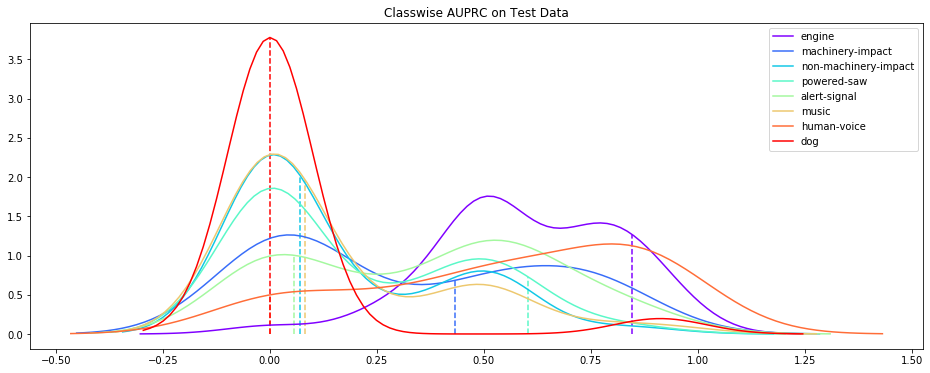

In [18]:
sid = 2 #56 #0, 2
evenly_spaced_interval = np.linspace(0, 1, len(metrics))
colors = [cm.rainbow(x) for x in evenly_spaced_interval]
test = test1[test1['sensor_id'] != sid]

fig, ax = plt.subplots(figsize=(16,6))
for i, metric in enumerate(metrics):
    labelname = metric + '|sensor_id=' + str(sid)
    s = test1[test1['sensor_id'] == sid].iloc[0][metric]
    sns.kdeplot(test[metric], color=colors[i], label=metric, ax=ax)
    
    xf, yf = ax.lines[i].get_data()
    y = np.interp(s, xf, yf)
    plt.vlines(s, ymin=0, ymax=y, color=colors[i], ls='--') #label=labelname
    
plt.legend()
plt.title(plot_title)
plt.show()